In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.mode.chained_assignment = None  # default='warn'

# Input data files are available in the read-only "../data/" directory

import os
import os.path as osp
from tqdm import tqdm
from collections import Counter

ds_name = 'TB'
date = '20230223'
ds_folder = f'/mnt/data2/chaoyue/data/ddf_{ds_name}_{date}'
for dirname, _, filenames in os.walk(ds_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/mnt/data2/chaoyue/data/ddf_TB_20230223/split_rs123/valid_edge.csv
/mnt/data2/chaoyue/data/ddf_TB_20230223/split_rs123/test.csv
/mnt/data2/chaoyue/data/ddf_TB_20230223/split_rs123/test_edge.csv
/mnt/data2/chaoyue/data/ddf_TB_20230223/split_rs123/train.csv
/mnt/data2/chaoyue/data/ddf_TB_20230223/split_rs123/train_edge.csv
/mnt/data2/chaoyue/data/ddf_TB_20230223/split_rs123/valid.csv


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
#import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
%matplotlib inline

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [5]:
#Import the files
train_node_df = pd.read_csv(f'{ds_folder}/split_rs123/train.csv')
train_edge_df = pd.read_csv(f'{ds_folder}/split_rs123/train_edge.csv')
valid_node_df = pd.read_csv(f'{ds_folder}/split_rs123/valid.csv')
valid_edge_df = pd.read_csv(f'{ds_folder}/split_rs123/valid_edge.csv')
test_node_df = pd.read_csv(f'{ds_folder}/split_rs123/test.csv')
test_edge_df = pd.read_csv(f'{ds_folder}/split_rs123/test_edge.csv')

In [6]:
train_node_df = pd.concat([train_node_df,valid_node_df], axis=0)
train_edge_df = pd.concat([train_edge_df,valid_edge_df], axis=0)

In [7]:
train_node_df

,index,sim,cluster_id,state,dynamic,node,dynamic_cat
0,3256,1002.0,Background,A,static,2,0
1,3257,1002.0,Background,A,static,1,0
2,3258,1002.0,Background,A,static,3,0
3,3259,1002.0,Background,A,static,6,0
4,3260,1002.0,Background,A,static,7,0
...,...,...,...,...,...,...,...
4089977,21411147,9995.0,c3,B,static,911,0
4089978,21411148,9995.0,c3,B,static,1340,0
4089979,21411149,9995.0,c3,B,static,1341,0
4089980,21411150,9995.0,c3,B,static,1747,0


In [8]:
train_edge_df

,sim,new_from,new_to,weight1_arsinh-norm,weight2_arsinh-norm
0,1002,1379,2,1.450970,2.252550
1,1002,1379,1380,0.238231,-0.287973
2,1002,1380,1,0.459961,0.098878
3,1002,1380,1381,0.928404,0.600251
4,1002,1381,1382,0.105893,-0.312866
...,...,...,...,...,...
4088540,9995,3181,3206,0.721286,0.348749
4088541,9995,3206,505,-1.656686,-1.051657
4088542,9995,3206,3207,0.105893,-0.218383
4088543,9995,3207,819,-1.094478,-0.910914


In [9]:
node_df = pd.concat([train_node_df,test_node_df], axis=0)
edge_df = pd.concat([train_edge_df,test_edge_df], axis=0)

In [10]:
node_df

,index,sim,cluster_id,state,dynamic,node,dynamic_cat
0,3256,1002.0,Background,A,static,2,0
1,3257,1002.0,Background,A,static,1,0
2,3258,1002.0,Background,A,static,3,0
3,3259,1002.0,Background,A,static,6,0
4,3260,1002.0,Background,A,static,7,0
...,...,...,...,...,...,...,...
4102469,21397711,9990.0,c3,C,static,38,0
4102470,21397712,9990.0,c3,C,static,83,0
4102471,21397713,9990.0,c3,C,static,1648,0
4102472,21397714,9990.0,c3,C,static,123,0


In [11]:
edge_df

,sim,new_from,new_to,weight1_arsinh-norm,weight2_arsinh-norm
0,1002,1379,2,1.450970,2.252550
1,1002,1379,1380,0.238231,-0.287973
2,1002,1380,1,0.459961,0.098878
3,1002,1380,1381,0.928404,0.600251
4,1002,1381,1382,0.105893,-0.312866
...,...,...,...,...,...
4101032,9990,1637,3084,0.554831,0.076240
4101033,9990,3084,2,-0.225758,-0.527804
4101034,9990,3084,3085,0.721286,0.494104
4101035,9990,3085,1,-0.719703,-0.829746


In [12]:
feat_dict = {'mean': [9.46956059e+00, 8.52283178e-03, 2.53821809e+00, 8.52239764e-03],
             'std': [8.06805104e+00, 7.29679147e-03, 1.00009538e+00, 7.29563256e-03]}

In [13]:
feat_dict

{'mean': [9.46956059, 0.00852283178, 2.53821809, 0.00852239764],
 'std': [8.06805104, 0.00729679147, 1.00009538, 0.00729563256]}

In [14]:
train_edge_df['weight1'] = np.sinh(train_edge_df['weight1_arsinh-norm'].values*feat_dict['std'][2]+feat_dict['mean'][2])
train_edge_df['weight2'] = np.sinh(train_edge_df['weight2_arsinh-norm'].values*feat_dict['std'][3]+feat_dict['mean'][3])

In [15]:
train_edge_df

,sim,new_from,new_to,weight1_arsinh-norm,weight2_arsinh-norm,weight1,weight2
0,1002,1379,2,1.450970,2.252550,27.0,0.024959
1,1002,1379,1380,0.238231,-0.287973,8.0,0.006421
2,1002,1380,1,0.459961,0.098878,10.0,0.009244
3,1002,1380,1381,0.928404,0.600251,16.0,0.012902
4,1002,1381,1382,0.105893,-0.312866,7.0,0.006240
...,...,...,...,...,...,...,...
4088540,9995,3181,3206,0.721286,0.348749,13.0,0.011067
4088541,9995,3206,505,-1.656686,-1.051657,1.0,0.000850
4088542,9995,3206,3207,0.105893,-0.218383,7.0,0.006929
4088543,9995,3207,819,-1.094478,-0.910914,2.0,0.001877


In [16]:
test_edge_df['weight1'] = np.sinh(test_edge_df['weight1_arsinh-norm'].values*feat_dict['std'][2]+feat_dict['mean'][2])
test_edge_df['weight2'] = np.sinh(test_edge_df['weight2_arsinh-norm'].values*feat_dict['std'][3]+feat_dict['mean'][3])
edge_df['weight1'] = np.sinh(edge_df['weight1_arsinh-norm'].values*feat_dict['std'][2]+feat_dict['mean'][2])
edge_df['weight2'] = np.sinh(edge_df['weight2_arsinh-norm'].values*feat_dict['std'][3]+feat_dict['mean'][3])

In [17]:
edge_df

,sim,new_from,new_to,weight1_arsinh-norm,weight2_arsinh-norm,weight1,weight2
0,1002,1379,2,1.450970,2.252550,27.0,0.024959
1,1002,1379,1380,0.238231,-0.287973,8.0,0.006421
2,1002,1380,1,0.459961,0.098878,10.0,0.009244
3,1002,1380,1381,0.928404,0.600251,16.0,0.012902
4,1002,1381,1382,0.105893,-0.312866,7.0,0.006240
...,...,...,...,...,...,...,...
4101032,9990,1637,3084,0.554831,0.076240,11.0,0.009079
4101033,9990,3084,2,-0.225758,-0.527804,5.0,0.004672
4101034,9990,3084,3085,0.721286,0.494104,13.0,0.012127
4101035,9990,3085,1,-0.719703,-0.829746,3.0,0.002469


In [18]:
edge_df.describe()

,sim,new_from,new_to,weight1_arsinh-norm,weight2_arsinh-norm,weight1,weight2
count,2.043959e+07,2.043959e+07,2.043959e+07,2.043959e+07,2.043959e+07,2.043959e+07,2.043959e+07
mean,4.992979e+03,2.352076e+03,1.541633e+03,1.127593e-04,1.114166e-04,9.470495e+00,8.523644e-03
std,2.894562e+03,5.574857e+02,9.303447e+02,1.000033e+00,9.999278e-01,8.067309e+00,7.296261e-03
min,1.000000e+00,1.300000e+01,1.000000e+00,-2.537976e+00,-1.168151e+00,1.106861e-08,-2.309345e-12
25%,2.504000e+03,1.980000e+03,7.280000e+02,-7.197030e-01,-8.128036e-01,3.000000e+00,2.592484e-03
50%,4.997000e+03,2.381000e+03,1.506000e+03,2.382315e-01,-1.670459e-01,8.000000e+00,7.303757e-03
75%,7.507000e+03,2.792000e+03,2.337000e+03,7.212857e-01,4.669594e-01,1.300000e+01,1.192944e-02
max,1.000000e+04,3.596000e+03,3.596000e+03,3.422467e+00,2.382701e+01,1.940000e+02,1.833679e-01


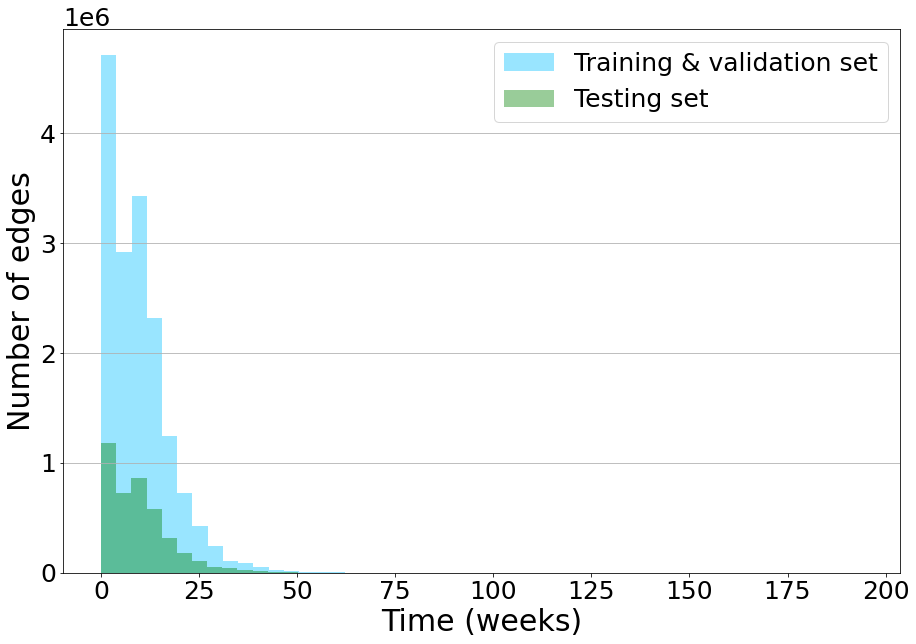

In [22]:
feats = ['weight1', 'weight2', 'weight1_arsinh-norm', 'weight2_arsinh-norm']
feat = feats[0]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_edge_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_edge_df[feat],bins=43,hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,3800000))
ax1.axes.set_ylabel("Number of edges",fontsize=30)
ax1.axes.set_xlabel(f"Time (weeks)",fontsize=30)
plt.grid(axis = "y")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
fig.savefig(f"./paper/dist/{ds_name}_{feat}.svg",dpi=600,format='svg')

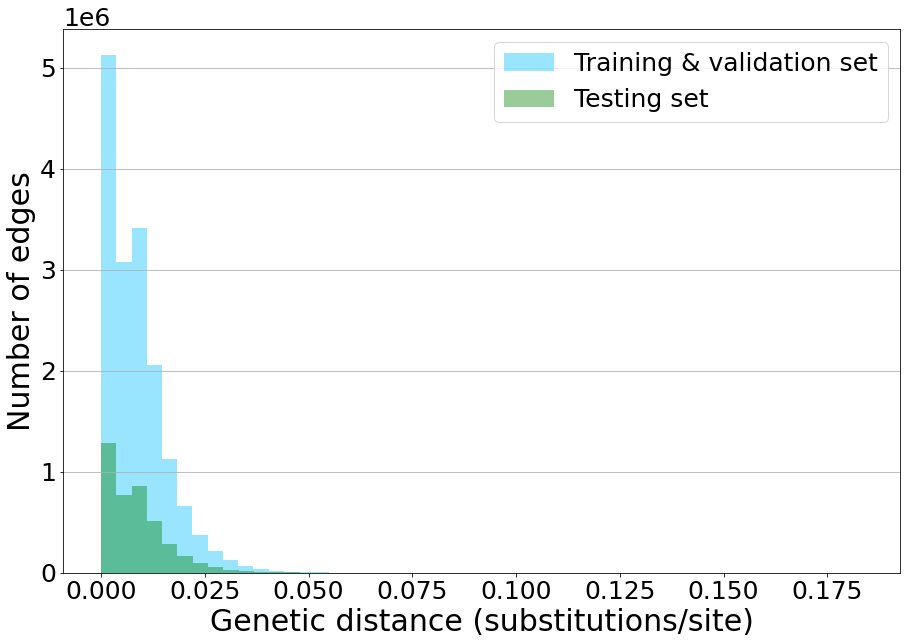

In [25]:
feat = feats[1]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_edge_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_edge_df[feat],bins=44,hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,3800000))
ax1.axes.set_ylabel("Number of edges",fontsize=30)
ax1.axes.set_xlabel(f"Genetic distance (substitutions/site)",fontsize=30)
plt.grid(axis = "y")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
fig.savefig(f"./paper/dist/{ds_name}_{feat}.svg",dpi=600,format='svg')

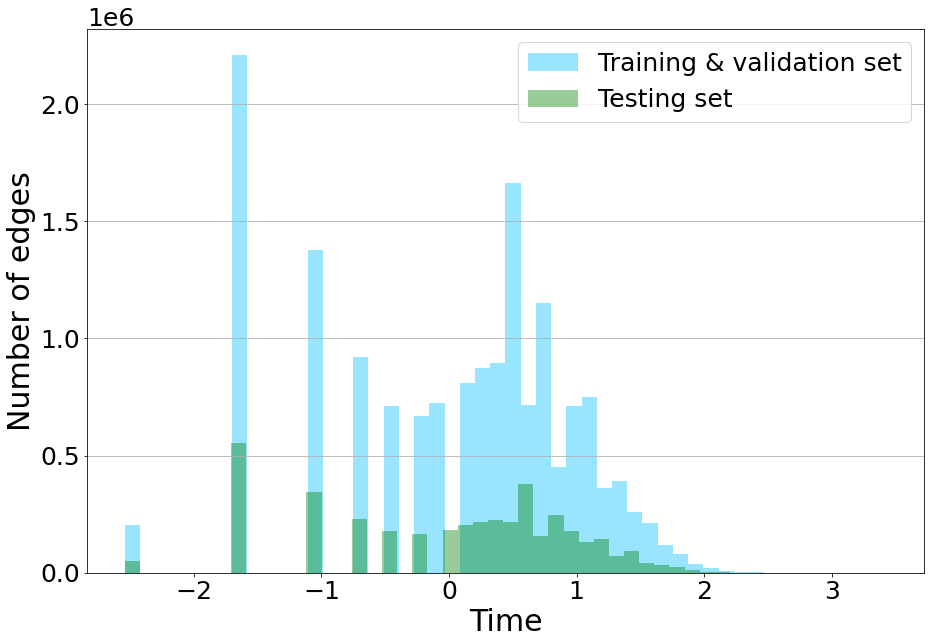

In [30]:
feat = feats[2]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_edge_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_edge_df[feat],bins=49,hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,3800000))
ax1.axes.set_ylabel("Number of edges",fontsize=30)
ax1.axes.set_xlabel(f"Time",fontsize=30)
plt.grid(axis = "y")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
fig.savefig(f"./paper/dist/{ds_name}_{feat}.svg",dpi=600,format='svg')

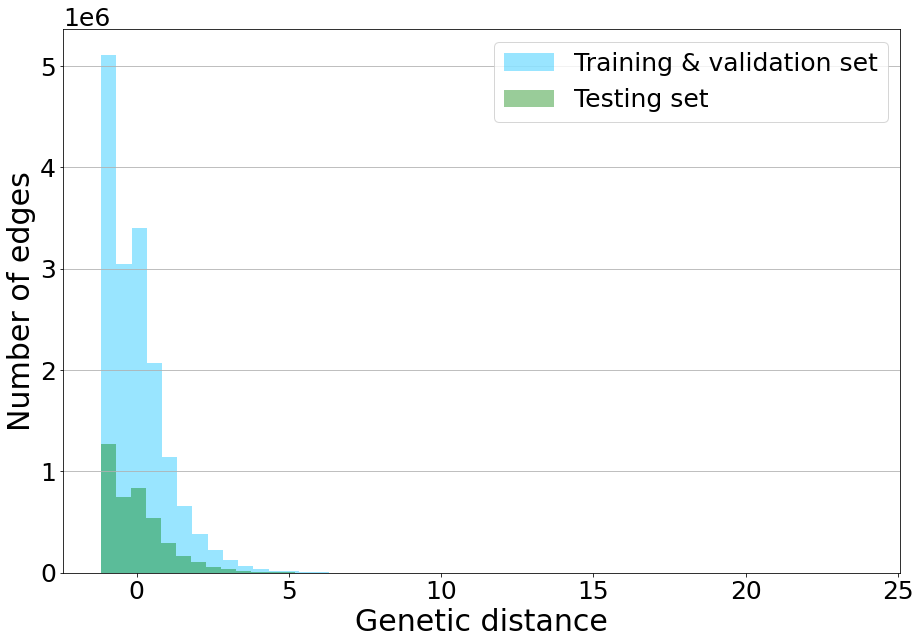

In [31]:
feat = feats[3]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_edge_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_edge_df[feat],bins=45,hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,3800000))
ax1.axes.set_ylabel("Number of edges",fontsize=30)
ax1.axes.set_xlabel(f"Genetic distance",fontsize=30)
plt.grid(axis = "y")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
fig.savefig(f"./paper/dist/{ds_name}_{feat}.svg",dpi=600,format='svg')

In [32]:
train_ids = train_edge_df['sim'].unique()
test_ids = test_edge_df['sim'].unique()

In [33]:
from collections import defaultdict
train_dist = defaultdict(list)
all_bg = []
for tree_id in train_ids:
    onetree_node_df = train_node_df[train_node_df['sim'] == tree_id] 
    num_nodes = onetree_node_df.shape[0]
    train_dist['sim'].append(tree_id)
    train_dist['num_nodes'].append(num_nodes)
    
    for label in ['static', 'growth', 'decay']:
        num_label_nodes = onetree_node_df[onetree_node_df['dynamic']==label].shape[0]
        train_dist[f'num_{label}_nodes'].append(num_label_nodes)
        train_dist[f'ratio_{label}_nodes'].append(num_label_nodes / num_nodes)  
    
train_dist_df = pd.DataFrame.from_dict(train_dist)

array([[<AxesSubplot:title={'center':'sim'}>,
        <AxesSubplot:title={'center':'num_nodes'}>,
        <AxesSubplot:title={'center':'num_static_nodes'}>],
       [<AxesSubplot:title={'center':'ratio_static_nodes'}>,
        <AxesSubplot:title={'center':'num_growth_nodes'}>,
        <AxesSubplot:title={'center':'ratio_growth_nodes'}>],
       [<AxesSubplot:title={'center':'num_decay_nodes'}>,
        <AxesSubplot:title={'center':'ratio_decay_nodes'}>,
        <AxesSubplot:>]], dtype=object)

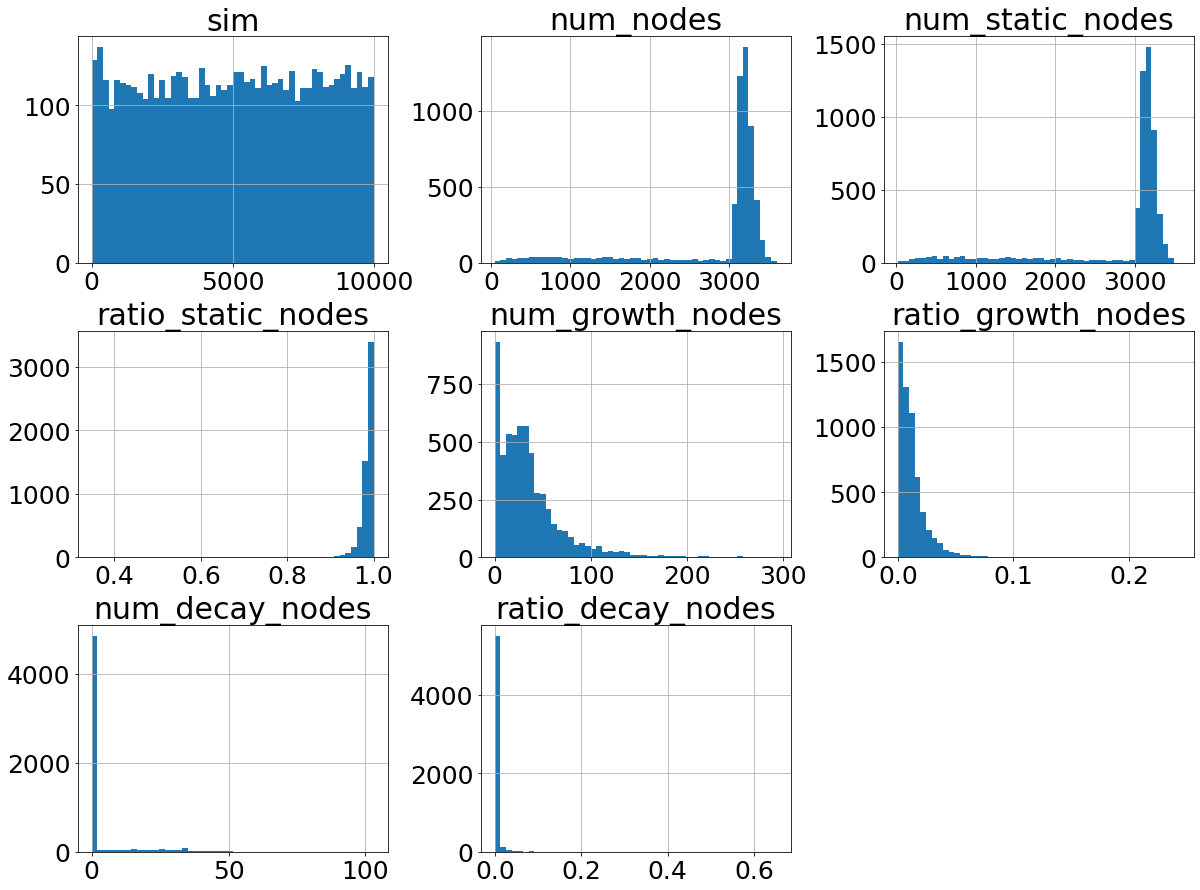

In [34]:
train_dist_df.hist(bins=50,figsize=(20,15))

In [35]:
from collections import defaultdict
test_dist = defaultdict(list)
for tree_id in test_ids:
    test_dist['sim'].append(tree_id)
    onetree_node_df = test_node_df[test_node_df['sim'] == tree_id] 
    num_nodes = onetree_node_df.shape[0]
    test_dist['num_nodes'].append(num_nodes)
    
    for label in ['static', 'growth', 'decay']:
        num_label_nodes = onetree_node_df[onetree_node_df['dynamic']==label].shape[0]
        test_dist[f'num_{label}_nodes'].append(num_label_nodes)
        test_dist[f'ratio_{label}_nodes'].append(num_label_nodes / num_nodes)
    
test_dist_df = pd.DataFrame.from_dict(test_dist)

array([[<AxesSubplot:title={'center':'sim'}>,
        <AxesSubplot:title={'center':'num_nodes'}>,
        <AxesSubplot:title={'center':'num_static_nodes'}>],
       [<AxesSubplot:title={'center':'ratio_static_nodes'}>,
        <AxesSubplot:title={'center':'num_growth_nodes'}>,
        <AxesSubplot:title={'center':'ratio_growth_nodes'}>],
       [<AxesSubplot:title={'center':'num_decay_nodes'}>,
        <AxesSubplot:title={'center':'ratio_decay_nodes'}>,
        <AxesSubplot:>]], dtype=object)

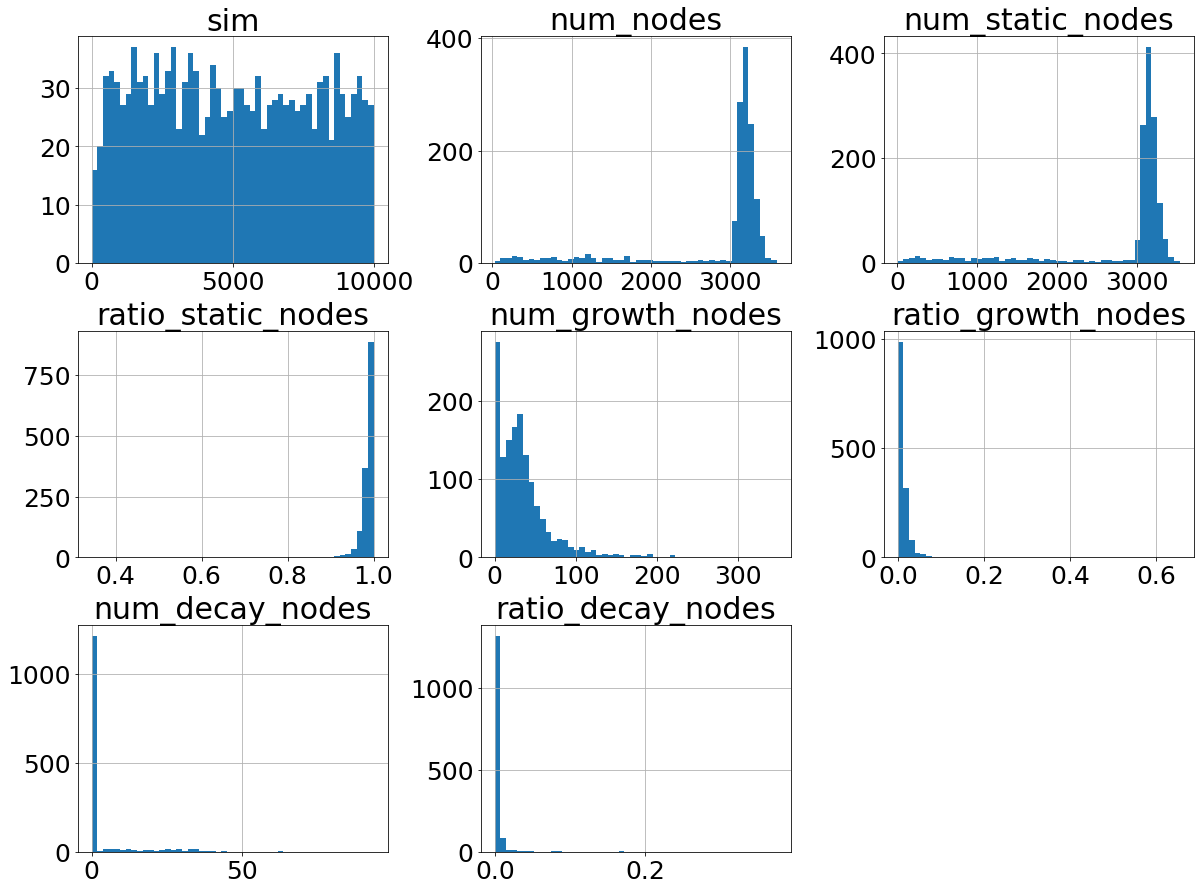

In [36]:
test_dist_df.hist(bins=50,figsize=(20,15))

In [37]:
test_dist_df.columns.values[1:]

array(['num_nodes', 'num_static_nodes', 'ratio_static_nodes',
       'num_growth_nodes', 'ratio_growth_nodes', 'num_decay_nodes',
       'ratio_decay_nodes'], dtype=object)

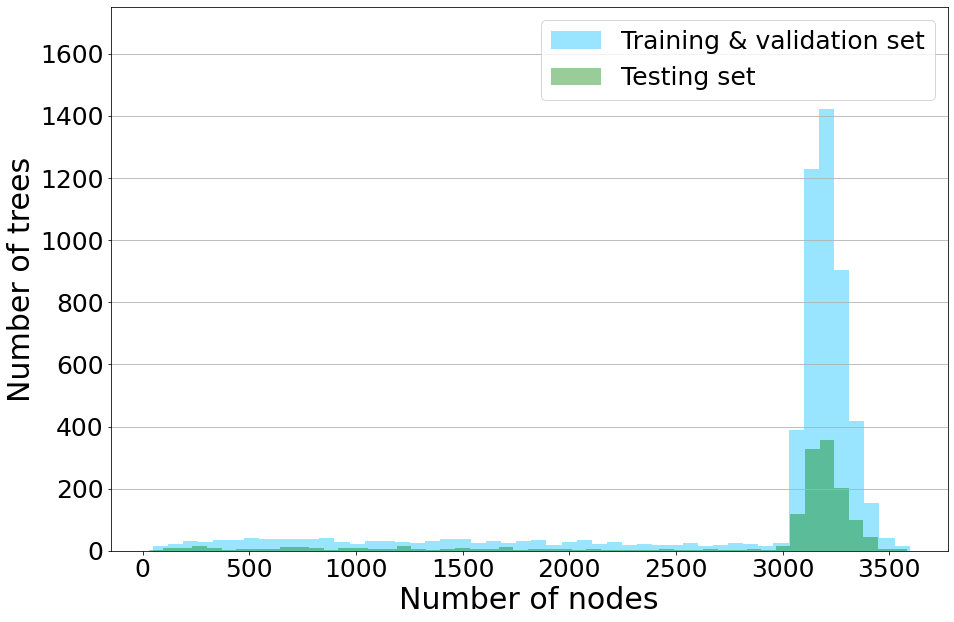

In [47]:
i = 0
feat = test_dist_df.columns.values[1:][i]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_dist_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_dist_df[feat],bins=52,hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
ax1.set(ylim=(0,1750))
ax1.axes.set_ylabel("Number of trees",fontsize=30)
ax1.axes.set_xlabel("Number of nodes",fontsize=30)
plt.grid(axis = "y")
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
fig.savefig(f"./paper/dist/{ds_name}_{feat}.svg",dpi=600,format='svg')

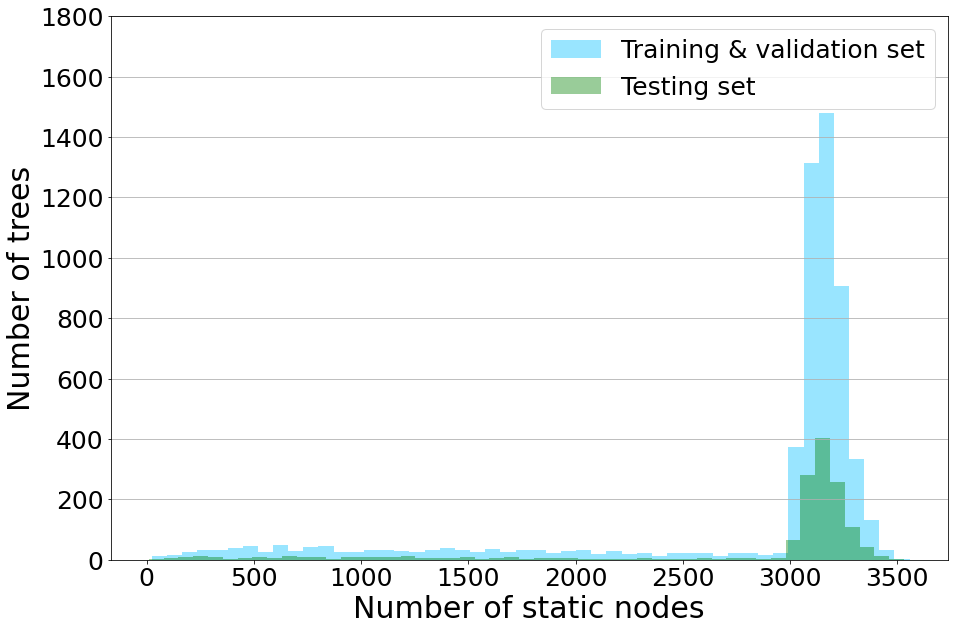

In [56]:
i = 1
feat = test_dist_df.columns.values[1:][i]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_dist_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_dist_df[feat],bins=51,hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
ax1.set(ylim=(0,1800))
ax1.axes.set_ylabel("Number of trees",fontsize=30)
ax1.axes.set_xlabel("Number of static nodes",fontsize=30)
plt.grid(axis = "y")
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
fig.savefig(f"./paper/dist/{ds_name}_{feat}.svg",dpi=600,format='svg')

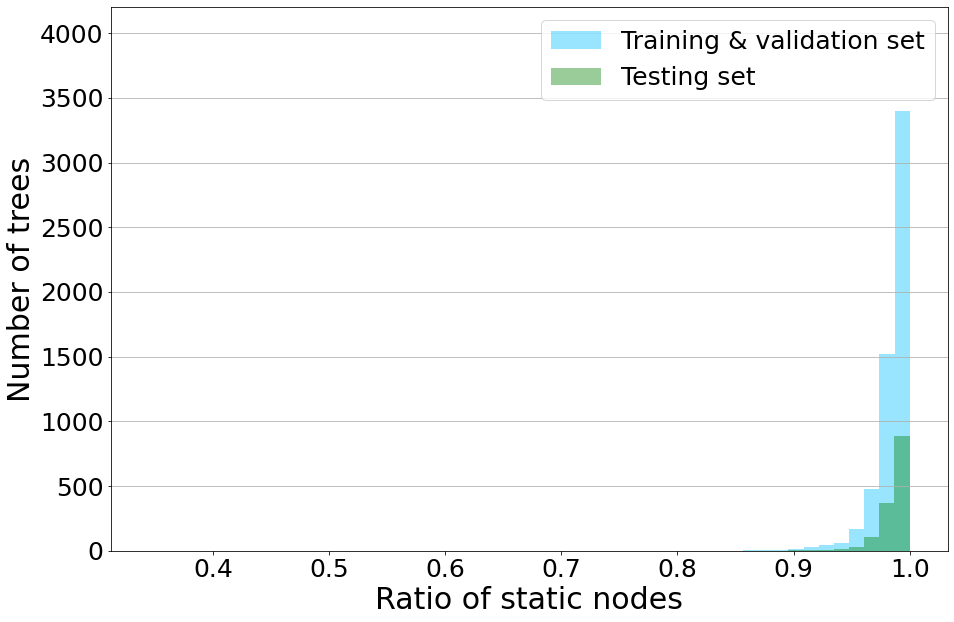

In [62]:
i = 2
feat = test_dist_df.columns.values[1:][i]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_dist_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_dist_df[feat],bins=50,hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
ax1.set(ylim=(0,4200))
ax1.axes.set_ylabel("Number of trees",fontsize=30)
ax1.axes.set_xlabel("Ratio of static nodes",fontsize=30)
plt.grid(axis = "y")
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
fig.savefig(f"./paper/dist/{ds_name}_{feat}.svg",dpi=600,format='svg')

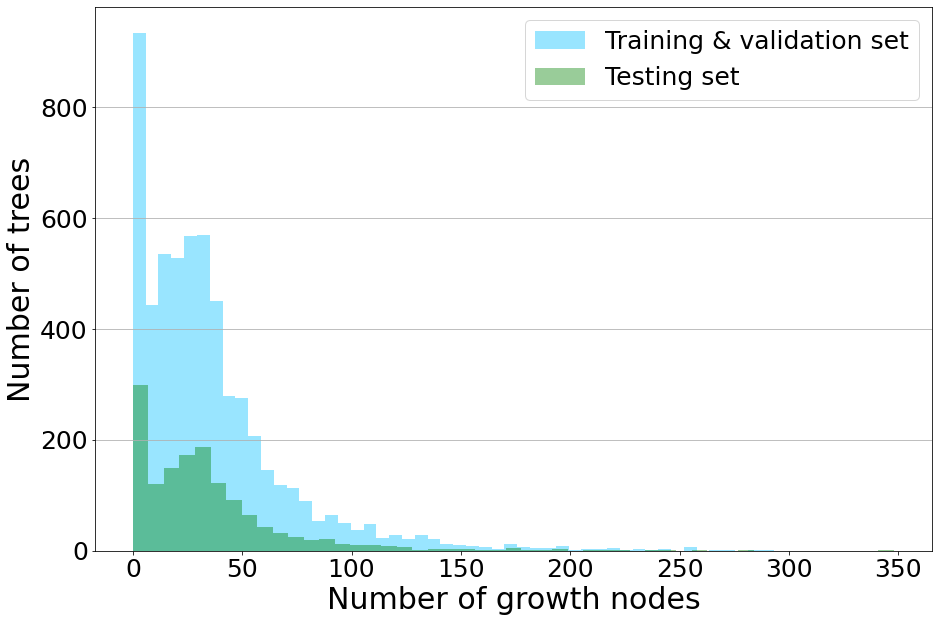

In [66]:
i = 3
feat = test_dist_df.columns.values[1:][i]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_dist_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_dist_df[feat],bins=49,hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,450))
ax1.axes.set_ylabel("Number of trees",fontsize=30)
ax1.axes.set_xlabel("Number of growth nodes",fontsize=30)
plt.grid(axis = "y")
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
fig.savefig(f"./paper/dist/{ds_name}_{feat}.svg",dpi=600,format='svg')

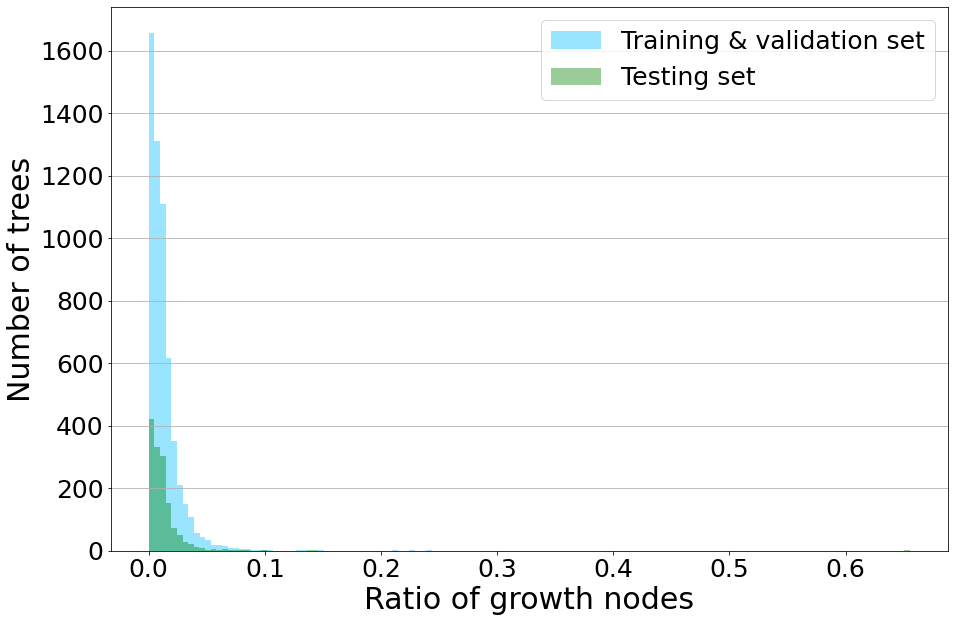

In [79]:
i = 4
feat = test_dist_df.columns.values[1:][i]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_dist_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_dist_df[feat],bins=135,hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,450))
ax1.axes.set_ylabel("Number of trees",fontsize=30)
ax1.axes.set_xlabel("Ratio of growth nodes",fontsize=30)
plt.grid(axis = "y")
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
fig.savefig(f"./paper/dist/{ds_name}_{feat}.svg",dpi=600,format='svg')

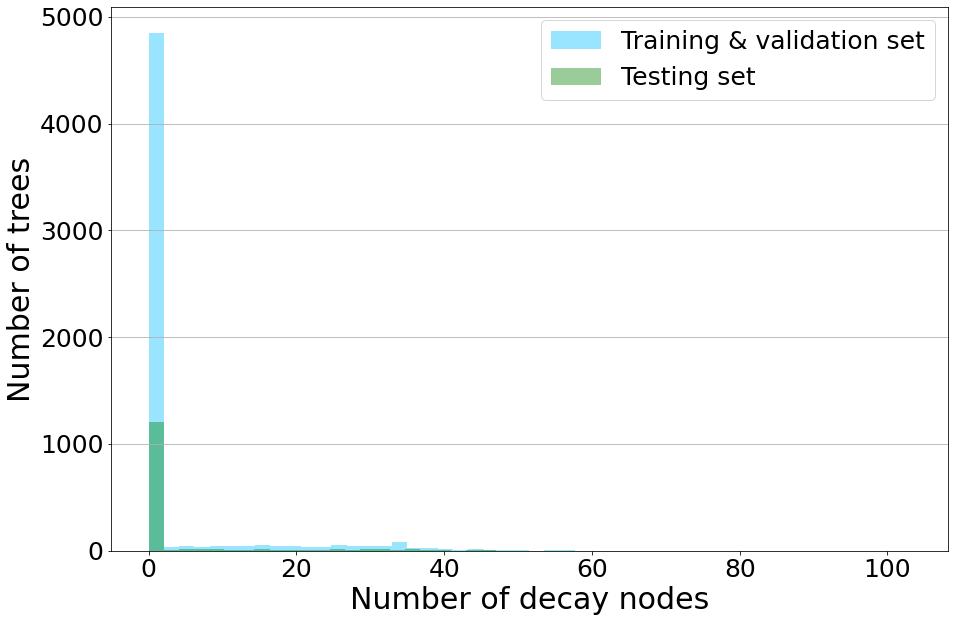

In [81]:
i = 5
feat = test_dist_df.columns.values[1:][i]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_dist_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_dist_df[feat],bins=46,hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,450))
ax1.axes.set_ylabel("Number of trees",fontsize=30)
ax1.axes.set_xlabel("Number of decay nodes",fontsize=30)
plt.grid(axis = "y")
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
fig.savefig(f"./paper/dist/{ds_name}_{feat}.svg",dpi=600,format='svg')

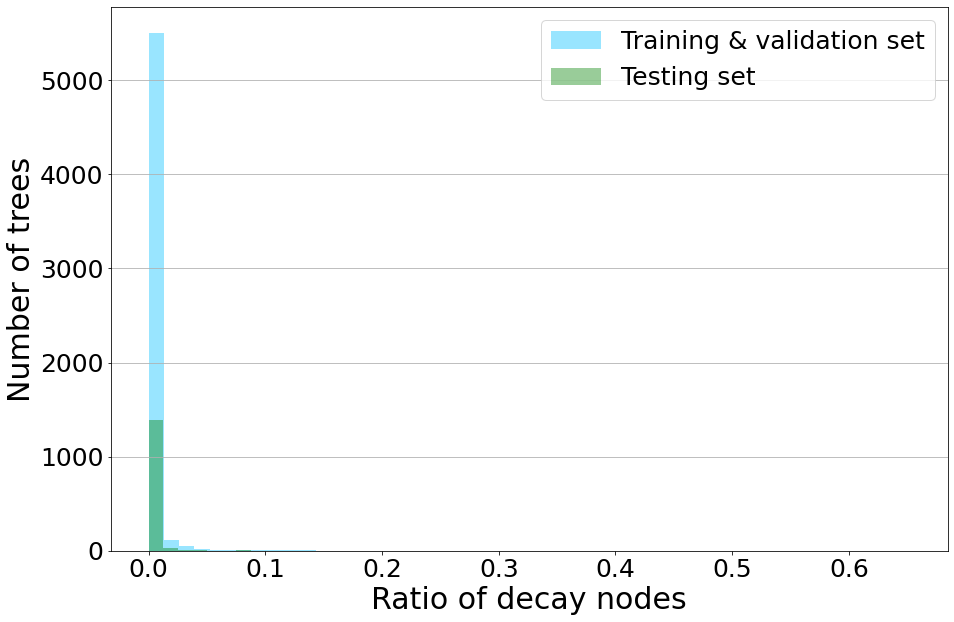

In [86]:
i = 6
feat = test_dist_df.columns.values[1:][i]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_dist_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_dist_df[feat],bins=30,hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,450))
ax1.axes.set_ylabel("Number of trees",fontsize=30)
ax1.axes.set_xlabel("Ratio of decay nodes",fontsize=30)
plt.grid(axis = "y")
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
fig.savefig(f"./paper/dist/{ds_name}_{feat}.svg",dpi=600,format='svg')